In [14]:
import pandas as pd
import nltk
import pymorphy2
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.cm as cm



data = pd.read_csv('data.csv', sep = ";", lineterminator='\n', on_bad_lines='skip', low_memory=False)  

In [15]:
SAMPLE = 1
TEST_PIPELINE = True
print(data["Текст"][SAMPLE])

if TEST_PIPELINE:
    texts_df = data["Текст"].head(5000).fillna("").astype("string").replace(to_replace='\n', value=' ',regex=True).replace(to_replace='\.', value=' ',regex=True).apply(lambda x: re.sub('[^# а-яА-Я]', '', x))
else:
    texts_df = data["Текст"].fillna("").astype("string").replace(to_replace='\n', value=' ',regex=True).replace(to_replace='\.', value=' ',regex=True).apply(lambda x: re.sub('[^# а-яА-Я]', '', x))

print(texts_df[SAMPLE])

8 ноября в рамках нашего проекта выступит психолог - Майя Козыренко с темой «Личные границы» 🧘‍♀️
Майя Козыренко - клинический психолог и гештальт-терапевт, ведущая терапевтических групп и мастер-классов 👩‍⚕️ Эксперт в области ментального здоровья и личностного роста.
«ДНК моей философии: Баланс во всём: в карьере/финансах, в отношениях/семье, в труде и отдыхе.»
🤔 В рамках тренинга "Личные границы" мы узнаем:
- что такое личные границы?
- какие существуют виды личных границ?
- что такое слияние и чем оно опасно?
- "Я - сообщение" vs "Вы - сообщение": в чём разница и как не задеть чувства собеседника?
- а если честно, то просто говорить про границы скучно, поэтому мы будем исследовать их на практике 😉
18:00
ЮРИУ РАНХиГС
107 аудитория
Ставь + в комменты, если планируешь прийти 🙌
 ноября в рамках нашего проекта выступит психолог  Майя Козыренко с темой Личные границы  Майя Козыренко  клинический психолог и гештальттерапевт ведущая терапевтических групп и мастерклассов  Эксперт в области м

In [16]:
morph = pymorphy2.MorphAnalyzer()
#Возможно, морфологичекий анализатор pymorphy2 слишком медленный
stemmer = nltk.stem.snowball.RussianStemmer()

def stem_words(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def lem_words(text):
    words = nltk.word_tokenize(text)
    lemmed_words = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmed_words)

texts_df_lem = texts_df.apply(lem_words)
print(texts_df_lem[SAMPLE])

ноябрь в рамка наш проект выступить психолог майя козыренко с тема личный граница майя козыренко клинический психолог и гештальттерапевт ведущий терапевтический группа и мастеркласс эксперт в область ментальный здоровье и личностный рост днк мой философия баланс в всм в карьерефинанс в отношенияхсемья в труд и отдых в рамка тренинг личный граница мы узнать что такой личный граница какой существовать вид личный граница что такой слияние и чем оно опасно я сообщение вы сообщение в чм разница и как не задеть чувство собеседник а если честно то просто говорить про граница скучно поэтому мы быть исследовать они на практика юриу ранхигс аудитория ставить в коммент если планировать прийти


In [17]:
stopwords = set(stopwords.words('russian'))

texts = texts_df_lem.to_list()
tf_idf = TfidfVectorizer(stop_words=stopwords,smooth_idf=False)

tf_idf.fit(texts)
idfs = tf_idf.idf_
lower_thresh = 3
upper_thresh = 6
not_often = idfs > lower_thresh
not_rare = idfs < upper_thresh

mask = not_often * not_rare

good_words = np.array(tf_idf.get_feature_names_out())[mask]

print(f"final dict_size = {good_words.size}")

final dict_size = 2538


In [18]:
def delete_bad_words(text, good_words):
    unfiltred_words = nltk.word_tokenize(text)
    words = list(filter(lambda x: x in good_words, unfiltred_words))
    return ' '.join(words)

texts_clean = texts_df_lem.apply(lambda x :delete_bad_words(x,good_words)).to_list()
with open(r'cigane_big.txt', 'w') as fp:
    fp.write('\n'.join(texts_clean))
    
print(texts_clean[SAMPLE])

рамка проект выступить психолог тема граница клинический психолог ведущий терапевтический группа мастеркласс эксперт область ментальный здоровье философия баланс всм труд отдых рамка граница узнать граница существовать вид граница оно сообщение сообщение чм разница чувство собеседник честно говорить граница поэтому исследовать практика аудитория ставить планировать прийти


In [19]:
texts_token = [[word for word in text.lower().split()] for text in texts_clean]
dictionary = corpora.Dictionary(texts_token)
corpus = [dictionary.doc2bow(text) for text in texts_token]
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)


In [20]:
topics = lda_model.show_topics(num_topics=-1, num_words=10)
for topic in topics:
    print(topic)
    

(0, '0.057*"книга" + 0.020*"автор" + 0.013*"фильм" + 0.010*"здоровье" + 0.010*"читать" + 0.007*"здоровый" + 0.007*"тело" + 0.006*"четыре" + 0.006*"ценность" + 0.006*"физический"')
(1, '0.010*"психолог" + 0.008*"игра" + 0.007*"проблема" + 0.007*"энергия" + 0.007*"карта" + 0.007*"состояние" + 0.006*"психологический" + 0.006*"практика" + 0.006*"ситуация" + 0.006*"консультация"')
(2, '0.016*"программа" + 0.015*"россия" + 0.013*"профессиональный" + 0.011*"проект" + 0.008*"участие" + 0.008*"область" + 0.008*"техника" + 0.008*"практика" + 0.007*"также" + 0.007*"конкурс"')
(3, '0.016*"школа" + 0.013*"встреча" + 0.009*"участник" + 0.009*"команда" + 0.009*"тренер" + 0.008*"мероприятие" + 0.007*"октябрь" + 0.007*"клуб" + 0.006*"проект" + 0.006*"ребята"')
(4, '0.015*"образование" + 0.015*"педагог" + 0.010*"душа" + 0.009*"красота" + 0.009*"творчество" + 0.009*"рождение" + 0.009*"спорт" + 0.008*"канал" + 0.008*"клуб" + 0.008*"здоровье"')
(5, '0.031*"обида" + 0.016*"цитата" + 0.012*"энергия" + 0.012*

In [21]:
lda_model.save("lda_model1")

In [22]:
document_topic = [lda_model.get_document_topics(item) for item in corpus]

In [23]:
from operator import itemgetter

print(document_topic[20])
print(data['Текст'][20])
max_index = max(document_topic[20], key = itemgetter(1))[0]
max_index

[(1, 0.13593858), (7, 0.84666055)]
Продолжаем рубрику "Вы (не) спрашивали, мы отвечаем".
Вопрос. А если хочется лежать на диване с гаджетом, телевизором и вкусняшками? Или круглосуточно играть в настолки? Или чередовать эти два занятия? Это же можно делать бесконечно))
Ответ. Это желание можно рассматривать как компульсию (неконтролируемое стремление делать что-то) и как вариант рекреации (восстановления).
В первом случае мы, как правило, имеем дело с замещением. Хочется одно, но оно недоступно, поэтому делаем другое. Это другое - и есть компульсия. Серфинг соцсетей, однотипные игры, алкоголизация - все это варианты компульсивных действий. Прислушиваться к себе, в частности, - и есть способ найти то, что хочется на самом деле и заняться этим. Это полезнее.
Однако все перечисленное может быть и вариантом рекреации. Не самым лучшим, конечно, но человеку не обязательно исправлять в своей жизни все подряд. Поэтому, если рекреация не вредит основной жизнедеятельности, то и ничего страшного.

7

<BarContainer object of 10 artists>

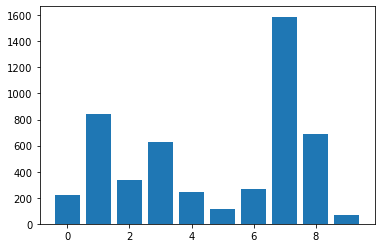

In [24]:
dist = np.zeros(10)
iterat = 0
for item in corpus:
    topics = lda_model.get_document_topics(item) 
    max_index = max(topics, key = itemgetter(1))[0]
    dist[max_index] = dist[max_index] + 1
    print(f"Iteration {iterat}", end = "\r")
    iterat = iterat + 1

dist
x = range(10)
plt.bar(x,dist)

In [25]:
def get_rand_sample(topic_number, model, curpus, data):
    topic = -1
    while(topic != topic_number):
        rand = np.random.randint(0,iterat)
        print(f"init rand doc {rand}", end = "\r")
        topics = model.get_document_topics(corpus[rand]) 
        topic = max(topics, key = itemgetter(1))[0]
    print(data['Текст'][rand])

Вот и второй месяц нового учебного года позади, а это значит, что​
с 1 ноября 2022г. стартует новый муниципальный ДЕТСКИЙ конкурс в системе "12 месяцев - 12 конкурсов" для детей старших и подготовительных групп - конкурс "Слово на ладошке". ?
❗️Цель конкурса: выявление лучших чтецов литературных произведений (стихов или прозы) среди детей старшего дошкольного возраста, поддержка талантливых и творческих детей, содействие их личностному росту.​
Тема конкурсных испытаний " Моя Россия".​ Для исполнения рекомендуются произведения патриотической направленности:​ о своей​ Родине, о природе родного края, о дружбе народов России.
Конкурс будет проходить в Детском саду с 21 по 25 ноября в двух​ корпусах.
​ 🍁участвуйте вместе с нами!
🍁творите!
🍁получайте призы!
❗️Желаем всем творческих успехов!​


In [31]:
get_rand_sample(5, lda_model, corpus, data)

Исполним твои мечты!?
Я - Ольга Будянская - практикующий рунолог, астролог,маг, таролог, ведьма, тренер по личностному росту и ораторскому мастерству. Предлагаю ВАМ СВОИ УСЛУГИ!
🌟СО МНОЙ ИСПОЛНЯЮТСЯ МЕЧТЫ 🌟
Астрологический прогноз
Рунический прогноз
Чистка чакр, биополя
Возврат любимого\любимой
Талисманы успеха в бизнесе
Талисманы для карьеры
Талисманы Защиты и Энергии
Талисманы для любви
Личные консультации.
Онлайн Консультации.
Обучение Рунической магии.
ПИШИТЕ🔽
Пишите прямо сейчас 🔽
INSTAGRAMM: @olga_budyanskaya
WhatsApp /Viber: +7(965)554-39-15
@olga_budyanskaya
@olga_budyanskaya
@olga_budyanskaya
olga_budyanskaya
